# **Decision tree**

Notes about the model:
- Non-parametric supervised learning method that can be used for classification, like the problem in study
- The goal is to create a model that predicts the value of Attiction by learning decision rules inferred from the data features
- The algorithm supports numeric and categorical variables, scikit-learn implementation does not support categorical variables directly so, as in other models, it will be required to handle those cases by using dummies
- Decision-tree  can create over-complex trees that do not generalize the data well - overfitting. If happens it will be necessary to recur to mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree. 

Support: https://scikit-learn.org/stable/modules/tree.html#


## **1. Import the model and necessary libraries**

In [12]:
# ============================================
# 1. IMPORTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

# Add parent directory to path for preprocessing import
sys.path.append('scripts')
from preprocessing import preprocess

import joblib
import json


In [13]:
#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
#                                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                                          max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                          class_weight=None, ccp_alpha=0.0, monotonic_cst=None)

## **2. Import data**

In [14]:
# ============================================
# 2. DATA PREPROCESSING
# ============================================
# Run preprocessing function directly
# Outputs: X_train, X_val, X_test, y_train, y_val, y_test (stratified, scaled, encoded)
# ============================================

X_train, X_val, X_test, y_train, y_val, y_test = preprocess(
    data_path='data/raw/HR_Attrition_Dataset.csv'
)

# Display basic info
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"\nClass distribution - Training:")
print(y_train.value_counts(normalize=True).round(3))


Training set: 882 samples, 18 features
Validation set: 294 samples
Test set: 294 samples

Features: ['JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobRole_Research Director', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently', 'WorkLifeBalance', 'Department_Research & Development', 'YearsAtCompanyLog', 'TotalWorkingYearsLog', 'MaritalStatus_Single', 'OverTime_Yes', 'JobRole_Laboratory Technician', 'JobRole_Manufacturing Director', 'MaritalStatus_Married', 'JobRole_Manager', 'NumCompaniesWorked', 'JobRole_Healthcare Representative']

Class distribution - Training:
Attrition
0    0.838
1    0.162
Name: proportion, dtype: float64


## **3. Implementing the model - Version 1**

### **3.1. Class Imbalance**

In this case, the class imbalance will be handled with the parameter class_weight - balanced. The next cell allows the pratic interpretation of the model.


In [15]:
# ============================================
# 3. CLASS IMBALANCE - CALCULATE CLASS_WEIGHT
# ============================================

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
imbalance_ratio = n_negative / n_positive

print(f"Class 0 (Stay): {n_negative}")
print(f"Class 1 (Leave): {n_positive}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
print(f"\nRecommended class_weight: {imbalance_ratio:.2f}")


Class 0 (Stay): 739
Class 1 (Leave): 143
Imbalance ratio: 5.17

Recommended class_weight: 5.17


In [16]:
# ============================================
# 4. DECISION TREE - HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# ============================================

# Set up StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Expanded hyperparameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  # 2
    'splitter': ['best', 'random'],  # 2
    'max_depth': [3, 5, 7],  # 3
    'min_samples_split': [2, 10, 20],  # 3
    'min_samples_leaf': [1, 4, 8],  # 3
    'min_weight_fraction_leaf': [0.0, 0.01],  # 2 (NEW: weighted leaf minimum)
    'max_features': [None, 'sqrt', 'log2'],  # 3
    'max_leaf_nodes': [None, 20, 50],  # 3 (NEW: limit tree size)
    'min_impurity_decrease': [0.0, 0.01],  # 2
    'ccp_alpha': [0.0, 0.01],  # 2 (NEW: cost-complexity pruning)
    'class_weight': [
        None, 
        'balanced',
        {0: 1, 1: 5}
    ]  # 3
}

# Total combinations: 2 × 2 × 3 × 3 × 3 × 2 × 3 × 3 × 2 × 2 × 3 = 23,328 combinations

print(f"Total hyperparameter combinations: {2*2*6*4*4*3*3*4}")

# Base classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# GridSearchCV with F1 scoring
grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Print results
print("=" * 60)
print("GRIDSEARCHCV RESULTS")
print("=" * 60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score (CV): {grid_search.best_score_:.4f}")

# Best estimator
best_dt = grid_search.best_estimator_


Total hyperparameter combinations: 13824
Fitting 5 folds for each of 23328 candidates, totalling 116640 fits
GRIDSEARCHCV RESULTS
Best Parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Best F1 Score (CV): 0.4300


During the training:
- When the model fails to predict an employee leaving (False Negative), it receives a penalty of 5
- When the model fails to predict an employee staying (False Positive), it receives a penalty of 1

The model is being penalized almost 5 times more when it doesn't identify correctly the employees that will leave the company.


Why These Parameters Matter for our Problem:
- max_leaf_nodes: HR needs interpretable models to explain to managers why someone is predicted to leave. Fewer leaves = simpler explanations.
- ccp_alpha: Your dataset is small (1470 samples) and imbalanced - trees easily overfit. Post-pruning helps generalization.
- min_weight_fraction_leaf: With class imbalance (84% stay, 16% leave), you don't want tiny leaves with just 1-2 leavers. This ensures statistical significance.
- max_depth=[3,5,7]: Shallow trees are easier to visualize and explain to business stakeholders.

In [17]:
# ============================================
# 5. THRESHOLD OPTIMIZATION - DUAL STRATEGY
# ============================================
# 1. F1-Optimized: Best balance between precision and recall
# 2. Recall-Optimized: Minimize surprise departures
# ============================================

# Get predicted probabilities on validation set
y_val_proba = best_dt.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# ---- F1-OPTIMIZED THRESHOLD ----
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
f1_achieved_recall = recalls[best_f1_idx]
f1_achieved_precision = precisions[best_f1_idx]
f1_achieved_f1 = f1_scores[best_f1_idx]

# ---- RECALL-OPTIMIZED THRESHOLD ----
TARGET_RECALL = 0.70  # Catch at least 70% of leavers

valid_indices = np.where(recalls[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[:-1][valid_indices])]
    recall_optimal_threshold = thresholds[best_idx]
    recall_achieved_recall = recalls[best_idx]
    recall_achieved_precision = precisions[best_idx]
else:
    recall_optimal_threshold = thresholds[0]
    recall_achieved_recall = recalls[0]
    recall_achieved_precision = precisions[0]
    print(f"WARNING: Target recall {TARGET_RECALL:.0%} not achievable. Using lowest threshold.")

print("=" * 60)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n{'F1-OPTIMIZED THRESHOLD':-<60}")
print(f"Threshold: {f1_optimal_threshold:.3f}")
print(f"Precision: {f1_achieved_precision:.2%}")
print(f"Recall: {f1_achieved_recall:.2%}")
print(f"F1 Score: {f1_achieved_f1:.3f}")

print(f"\n{'RECALL-OPTIMIZED THRESHOLD':-<60}")
print(f"Target Recall: {TARGET_RECALL:.0%}")
print(f"Threshold: {recall_optimal_threshold:.3f}")
print(f"Precision: {recall_achieved_precision:.2%}")
print(f"Recall: {recall_achieved_recall:.2%}")
print("=" * 60)


THRESHOLD OPTIMIZATION RESULTS

F1-OPTIMIZED THRESHOLD--------------------------------------
Threshold: 0.775
Precision: 47.83%
Recall: 46.81%
F1 Score: 0.473

RECALL-OPTIMIZED THRESHOLD----------------------------------
Target Recall: 70%
Threshold: 0.320
Precision: 27.13%
Recall: 74.47%


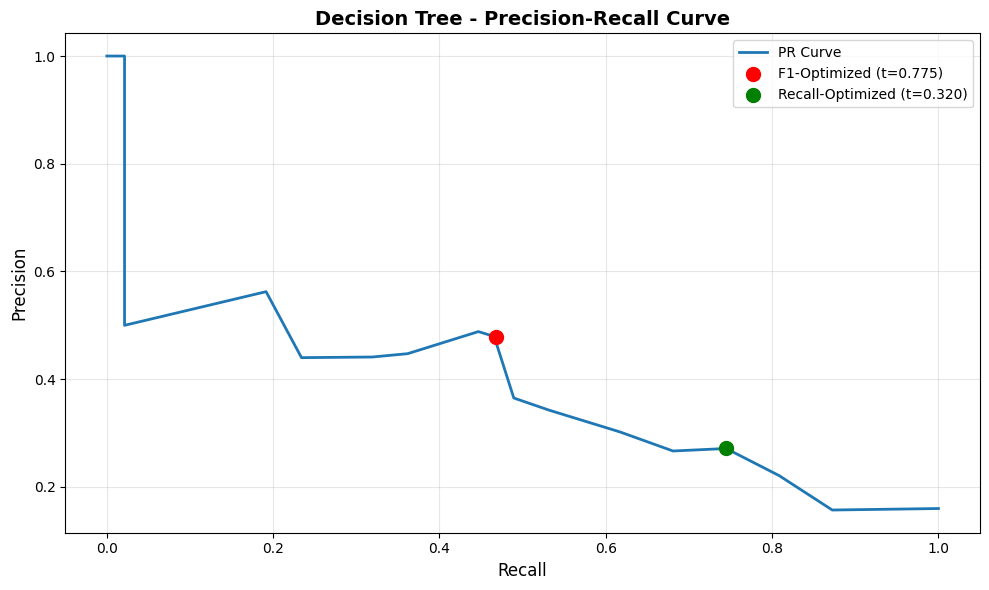

In [18]:
# ============================================
# 6. VISUALIZE PRECISION-RECALL TRADEOFF
# ============================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot Precision-Recall curve
ax.plot(recalls, precisions, label='PR Curve', linewidth=2)
ax.scatter([f1_achieved_recall], [f1_achieved_precision], 
           color='red', s=100, zorder=5, label=f'F1-Optimized (t={f1_optimal_threshold:.3f})')
ax.scatter([recall_achieved_recall], [recall_achieved_precision], 
           color='green', s=100, zorder=5, label=f'Recall-Optimized (t={recall_optimal_threshold:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Decision Tree - Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
# ============================================
# 7. EVALUATE ON TEST SET - ALL THRESHOLDS
# ============================================

# Get test probabilities
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

# Default threshold (0.5)
y_test_pred_default = best_dt.predict(X_test)

# F1-optimized threshold
y_test_pred_f1 = (y_test_proba >= f1_optimal_threshold).astype(int)

# Recall-optimized threshold
y_test_pred_recall = (y_test_proba >= recall_optimal_threshold).astype(int)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_test_proba)

print("=" * 60)
print("TEST SET EVALUATION - DECISION TREE")
print("=" * 60)
print(f"\nAUC Score: {auc_score:.3f}\n")

# Function to print metrics
def print_metrics(y_true, y_pred, threshold_name):
    print(f"\n{'='*60}")
    print(f"{threshold_name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Stay', 'Leave']))
    print(f"Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Calculate missed departures
    cm = confusion_matrix(y_true, y_pred)
    false_negatives = cm[1, 0]
    print(f"\nMissed Departures (False Negatives): {false_negatives}")

# Evaluate all thresholds
print_metrics(y_test, y_test_pred_default, "DEFAULT THRESHOLD (0.50)")
print_metrics(y_test, y_test_pred_f1, f"F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print_metrics(y_test, y_test_pred_recall, f"RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")


TEST SET EVALUATION - DECISION TREE

AUC Score: 0.724


DEFAULT THRESHOLD (0.50)
              precision    recall  f1-score   support

        Stay       0.89      0.75      0.81       247
       Leave       0.29      0.53      0.37        47

    accuracy                           0.71       294
   macro avg       0.59      0.64      0.59       294
weighted avg       0.80      0.71      0.74       294

Confusion Matrix:
[[185  62]
 [ 22  25]]

Missed Departures (False Negatives): 22

F1-OPTIMIZED THRESHOLD (0.775)
              precision    recall  f1-score   support

        Stay       0.90      0.91      0.91       247
       Leave       0.51      0.47      0.49        47

    accuracy                           0.84       294
   macro avg       0.71      0.69      0.70       294
weighted avg       0.84      0.84      0.84       294

Confusion Matrix:
[[226  21]
 [ 25  22]]

Missed Departures (False Negatives): 25

RECALL-OPTIMIZED THRESHOLD (0.320)
              precision    recall

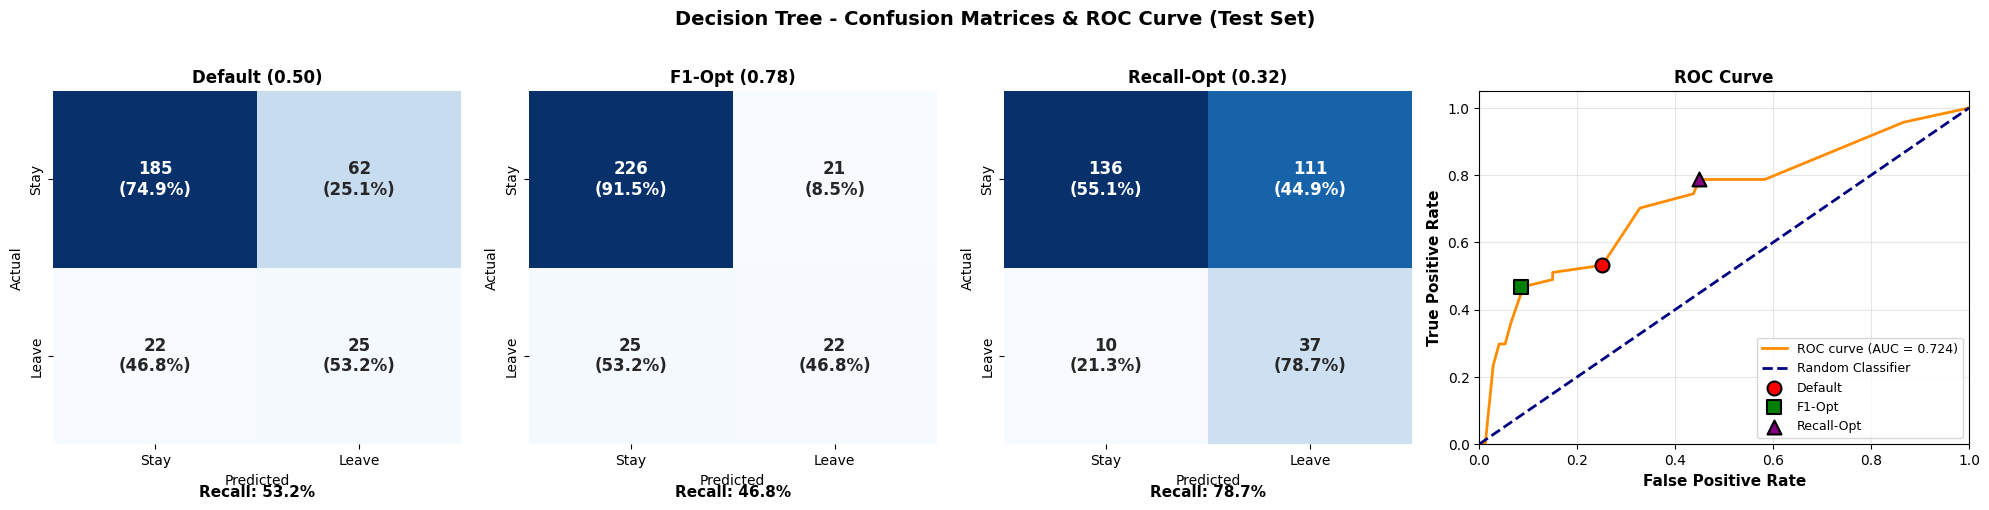

In [20]:
# ============================================
# VISUALIZE CONFUSION MATRICES WITH PERCENTAGES + ROC CURVE
# ============================================

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.2])

# First 3 subplots for confusion matrices
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

thresholds_data = [
    ("Default (0.50)", y_test_pred_default),
    (f"F1-Opt ({f1_optimal_threshold:.2f})", y_test_pred_f1),
    (f"Recall-Opt ({recall_optimal_threshold:.2f})", y_test_pred_recall)
]

for idx, (title, y_pred) in enumerate(thresholds_data):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with counts and percentages
    annot = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
                       for j in range(cm.shape[1])] 
                      for i in range(cm.shape[0])])
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=['Stay', 'Leave'],
                yticklabels=['Stay', 'Leave'],
                cbar=False, ax=axes[idx],
                annot_kws={'size': 12, 'weight': 'bold'})
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    
    # Add recall at bottom
    recall = recall_score(y_test, y_pred)
    axes[idx].text(0.5, -0.15, f'Recall: {recall:.1%}', 
                   transform=axes[idx].transAxes,
                   fontsize=11, fontweight='bold',
                   horizontalalignment='center')

# Fourth subplot for ROC curve
ax_roc = fig.add_subplot(gs[0, 3])

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Mark the threshold points
for threshold_name, y_pred, color, marker in [
    ("Default", y_test_pred_default, 'red', 'o'),
    ("F1-Opt", y_test_pred_f1, 'green', 's'),
    ("Recall-Opt", y_test_pred_recall, 'purple', '^')
]:
    cm = confusion_matrix(y_test, y_pred)
    fpr_point = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # FP / (TN + FP)
    tpr_point = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)
    ax_roc.scatter([fpr_point], [tpr_point], s=100, c=color, marker=marker, 
                   edgecolors='black', linewidths=1.5, label=threshold_name, zorder=5)

ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=9)
ax_roc.grid(alpha=0.3)

plt.suptitle('Decision Tree - Confusion Matrices & ROC Curve (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



Top 10 Most Important Features:
                              Feature  Importance
11                       OverTime_Yes    0.150594
16                 NumCompaniesWorked    0.128229
12      JobRole_Laboratory Technician    0.102707
0                     JobSatisfaction    0.101518
9                TotalWorkingYearsLog    0.087752
8                   YearsAtCompanyLog    0.082392
4        JobRole_Sales Representative    0.080427
7   Department_Research & Development    0.072784
2             EnvironmentSatisfaction    0.057039
1                      JobInvolvement    0.051431


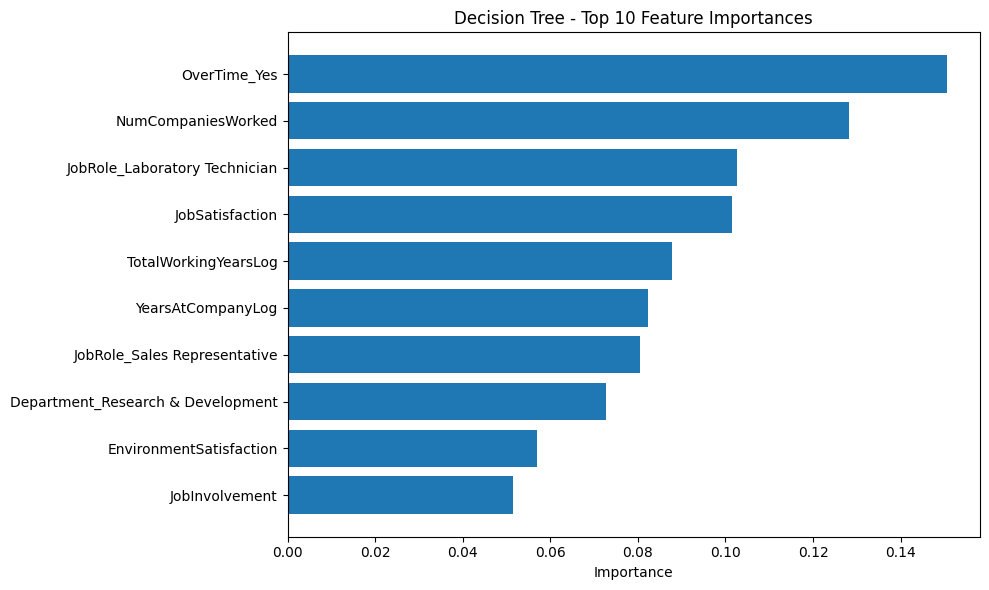

In [21]:
# ============================================
# 8. FEATURE IMPORTANCE
# ============================================

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10)[::-1], 
         feature_importance['Importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.title('Decision Tree - Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [22]:
# ============================================
# 9. SAVE MODEL AND METADATA
# ============================================

# Save model
model_path = 'models/dt_attrition_model.joblib'
joblib.dump(best_dt, model_path)

# Save metadata
metadata = {
    'model_type': 'DecisionTreeClassifier',
    'best_params': grid_search.best_params_,
    'best_cv_f1': float(grid_search.best_score_),
    'auc_score': float(auc_score),
    'thresholds': {
        'default': 0.5,
        'f1_optimized': float(f1_optimal_threshold),
        'recall_optimized': float(recall_optimal_threshold)
    },
    'feature_importance': feature_importance.to_dict('records')
}

metadata_path = 'models/dt_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved to: {model_path}")
print(f"Metadata saved to: {metadata_path}")



Model saved to: models/dt_attrition_model.joblib
Metadata saved to: models/dt_model_metadata.json
